# Battle of Neighborhoods

<b>Importing the required libraries at first</b>

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<b>Loading the JSON file which consists the datset of New York City</b>

In [2]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

<b>Extracting the necessary data from the JSON file</b>

In [4]:
neighborhoods_data = newyork_data['features']

In [5]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

<b>Converting the JSON data to Pandas datframe and assigning column names to the dataframe</b>

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [7]:
for data in neighborhoods_data:
    #Adding each row from the JSON data to the Pandas dataframe
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


<b>We have succesfully converted the JSON data to a Pandas Dataframe. We can now calculate the total number of boroughs and neighbourhoods in New York City.</b>

In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


<b>Using Geocode we can find the Latitude and Longitude of New York City by passing the address</b>

In [10]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


<b>We can now plot a map of New York City with markers marking the Borough and Neighbourhood with the help of Folium</b>

In [11]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

<b>We define a function get details which accept the latitude and longitude as parameters, and retuen the Name and IDs of all
Gyms/Fitness Centres within a defined radius of the latitude, longitude. The function takes the help of Foursquare API.</b>

In [12]:
def get_details(lat, lon):
    CLIENT_ID = 'EAEUHYB544QDFZDJNSZELDDBITDYIVSJT245QCJSDGVPUXTW' #My CLient ID
    CLIENT_SECRET = 'UOOI3ESFWE0TSU0VEQH2BV0UYDZZGUCMJXYZ2M3IZ1LJRMUN' #My Client Secret
    LIMIT = 30
    VERSION = '20180604'
    search_query = 'Gym / Fitness Center'
    radius = 500
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lon, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    # assign relevant part of JSON to venues
    venues = results['response']['venues']

    # tranform venues into a dataframe
    dataframe = pd.json_normalize(venues)
    venue_details=[]
    try:
        venue_id=dataframe['id']
        venue_name=dataframe['name']
        venue_details.append([venue_id,venue_name])
    except KeyError:
        pass
    return venue_details

<b>With the help of get_details function, we store the name and IDs of all Gyms/Fitness Centres of the Neighborhoods in a single 
    dataframe which contains the Borough, Neighbourhood, ID and Name</b>

In [13]:
# #prepare neighborhood list that contains gyms/fitness centres
# column_names=['Borough', 'Neighborhood', 'ID','Name','Latitude','Longitude']
# gym_ny=pd.DataFrame(columns=column_names)
# count=1
# for row in neighborhoods.values.tolist():
#     Borough, Neighborhood, Latitude, Longitude=row
#     gym = get_details(Latitude, Longitude)   
#     print('(',count,'/',len(neighborhoods),')','Gyms/Fitness Centres in '+Neighborhood+', '+Borough+':'+str(len(gym)))
#     for gym_detail in gym:
#         id, name=gym_detail
#         gym_ny = gym_ny.append({'Borough': Borough,
#                                                 'Neighborhood': Neighborhood, 
#                                                 'ID': id,
#                                                 'Name' : name,
#                                                 'Latitude' : Latitude,
#                                                 'Longitude' : Longitude
#                                                }, ignore_index=True)
#     count+=1

In [14]:
gym_ny = pd.read_csv('GymDetails_NY.csv')
gym_ny.drop(['Unnamed: 0'], axis=1, inplace=True)
gym_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Kingsbridge,"0 53fbbab3498e41f50c2fac75\nName: id, dtype...",0 3210 Riverdale Avenue - Wellness Center &...
1,Manhattan,Marble Hill,0 4cf6ae55d3a8a1cd71a9d243\n1 4aa00bcdf9...,0 Astral Fitness & Wellness Center\n1 ...
2,Bronx,Pelham Parkway,"0 4e595e67b3ad589d1a25c8db\nName: id, dtype...","0 Bronx House Fitness\nName: name, dtype: o..."
3,Bronx,Soundview,"0 4de1b36fd4c07044055ba685\nName: id, dtype...","0 NYPD Fitness Center\nName: name, dtype: o..."
4,Bronx,Country Club,"0 4d264370915fa093c3c8e809\nName: id, dtype...","0 Insanity Fitness Center\nName: name, dtyp..."


<b>Saving the datframw in a CSV file</b>

In [15]:
# gym_ny.to_csv('GymDetails_NY.csv')

<b>We can now get the total number of Gyms/Fitness Centres in New york City</b>

In [16]:
gym_ny.shape

(85, 4)

<b>We can plot the number of Gyms/Fitness Centres for each Borough in New York City on a Bar Graph with the help of matplotlib</b>

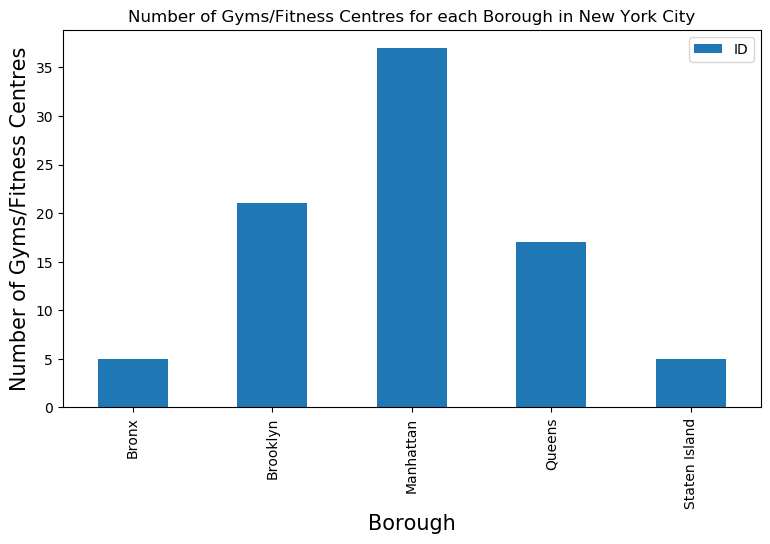

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Gyms/Fitness Centres for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of Gyms/Fitness Centres', fontsize=15)
#giving a bar plot
gym_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

<b>From the above Bar Graph, we find that Manhattan has the highest number of Gyms/Fitness Centres.</b>
    
<b>We can also plot the number of Gyms/Fitness Centres for each Neighborhood in New York City on a Bar Graph with the help of matplotlib</b>

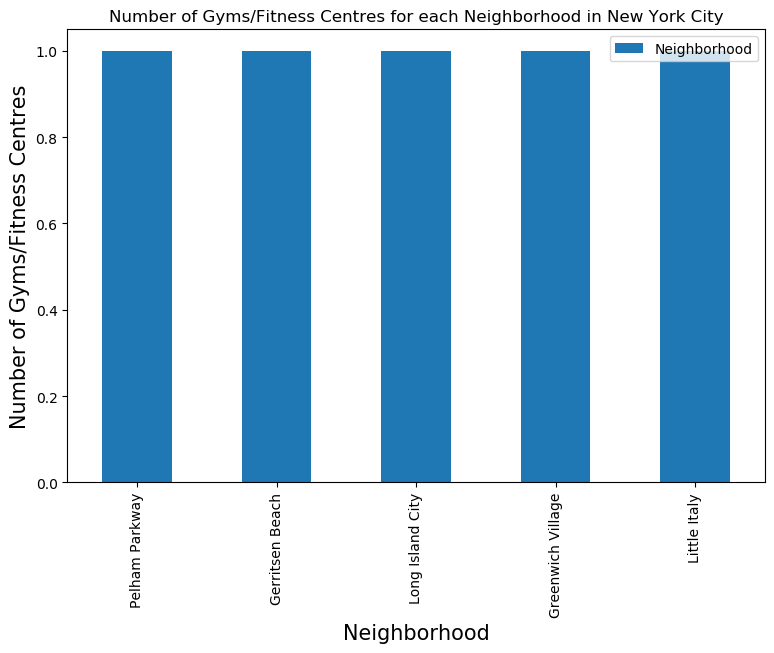

In [18]:
plt.figure(figsize=(9,6), dpi = 100)
# title
plt.title('Number of Gyms/Fitness Centres for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Number of Gyms/Fitness Centres', fontsize=15)
#giving a bar plot
gym_ny['Neighborhood'].value_counts().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

<b>From the above graph, we find that the top 5 neighbouhoods have similar frequency and it is difficult for us to conclude which has the highest number. Thus, we analyze the neighborhoods of Manhattan.</b>

In [19]:
criteria = gym_ny['Borough']=='Manhattan'
manhattan_gym = gym_ny[criteria]
manhattan_gym.head()

,Borough,Neighborhood,ID,Name
1,Manhattan,Marble Hill,0 4cf6ae55d3a8a1cd71a9d243\n1 4aa00bcdf9...,0 Astral Fitness & Wellness Center\n1 ...
23,Manhattan,Chinatown,0 4d95e867c19fb60cc4e57065\n1 598f070159...,0 Fitness Center\n1 Fi...
24,Manhattan,Inwood,"0 50674d07e4b0da4f1fd971d4\nName: id, dtype...","0 bally fitness center\nName: name, dtype: ..."
25,Manhattan,Hamilton Heights,0 4b9fad13f964a520e83337e3\n1 53f6a16649...,0 City College Fitness Center\n1 Melb...
26,Manhattan,Central Harlem,"0 4d042ad28620224ba18ca740\nName: id, dtype...",0 Lt Joseph P Kennedy Jr Community Center G...


<b>We count the number of Gyms/Fitness Centres in each of the neighborhoods of Manhattan</b>

In [20]:
manhattan_gym['Neighborhood'].value_counts()

Hudson Yards           1
West Village           1
East Village           1
Little Italy           1
Gramercy               1
Flatiron               1
Noho                   1
Civic Center           1
Roosevelt Island       1
Midtown                1
Murray Hill            1
Tudor City             1
Lincoln Square         1
Manhattan Valley       1
Chinatown              1
Turtle Bay             1
Yorkville              1
Morningside Heights    1
Greenwich Village      1
Central Harlem         1
Sutton Place           1
Lower East Side        1
East Harlem            1
Clinton                1
Marble Hill            1
Midtown South          1
Chelsea                1
Inwood                 1
Lenox Hill             1
Battery Park City      1
Financial District     1
Hamilton Heights       1
Soho                   1
Tribeca                1
Upper West Side        1
Upper East Side        1
Carnegie Hill          1
Name: Neighborhood, dtype: int64

<b>We visualize all the neighborhoods in Manhattan having GYMs or Fitness Centres</b>

In [27]:
address = 'Manhattan, New York'
geolocator = Nominatim(user_agent="ny_explorer", timeout=100)
location = geolocator.geocode(address)
lat = location.latitude
lng = location.longitude
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=30)
map_manhattan

# add markers to map
for name, neighborhood in zip(manhattan_gym['Name'], manhattan_gym['Neighborhood']):
    address = neighborhood
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    lat = location.latitude
    lng = location.longitude
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork